# Sentiment Analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data for sentiment training

In [3]:
# source is separated by tabs and has no headers
df_yelp = pd.read_csv('/content/drive/MyDrive/Capstone Project/yelp_labelled.txt', header = None, sep = '\t')
df_imdb = pd.read_csv('/content/drive/MyDrive/Capstone Project/imdb_labelled.txt', header = None, sep = '\t')
df_amazon = pd.read_csv('/content/drive/MyDrive/Capstone Project/amazon_cells_labelled.txt', header = None, sep = '\t')
dfs = {'yelp': df_yelp, 'imdb': df_imdb, 'amazon': df_amazon}

In [4]:
dfs

{'yelp':                                                      0  1
 0                             Wow... Loved this place.  1
 1                                   Crust is not good.  0
 2            Not tasty and the texture was just nasty.  0
 3    Stopped by during the late May bank holiday of...  1
 4    The selection on the menu was great and so wer...  1
 ..                                                 ... ..
 995  I think food should have flavor and texture an...  0
 996                           Appetite instantly gone.  0
 997  Overall I was not impressed and would not go b...  0
 998  The whole experience was underwhelming, and I ...  0
 999  Then, as if I hadn't wasted enough of my life ...  0
 
 [1000 rows x 2 columns],
 'imdb':                                                      0  1
 0    A very, very, very slow-moving, aimless movie ...  0
 1    Not sure who was more lost - the flat characte...  0
 2    Attempting artiness with black & white and cle...  0
 3         V

## Inspect the data

In [5]:
# - assign column names
# - add the data source
# - check the data
for ds in dfs.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs[ds].shape[0], dfs[ds].shape[1]))
    dfs[ds].columns = ['text', 'sentiment']
    dfs[ds]['source'] = ds
    print(dfs[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [748 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1   

## Merge the data

In [6]:
df = pd.concat(dfs.values(), ignore_index = True)

In [7]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))
print('-' * 75)

Dataset: All [2748 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2748 non-null   object
 1   sentiment  2748 non-null   int64 
 2   source     2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.5+ KB
None
                                                   text  sentiment  source
1121        I'll even say it again  this is torture.            0    imdb
1737  :) Anyway, the plot flowed smoothly and the ma...          1    imdb
2540                                       Great Phone.          1  amazon
1135  You'll love it!  \t1\nThis movie is BAD.  \t0\...          1    imdb
1153  Even if you love bad movies, do not watch this...          0    imdb
1489                              10 out of 10 stars.            1    imdb
1754  If you have several dozen or several hundred c...          0  amazon
2305

In [8]:
df.shape

(2748, 3)

In [9]:
df

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
2743,The screen does get smudged easily because it ...,0,amazon
2744,What a piece of junk.. I lose more calls on th...,0,amazon
2745,Item Does Not Match Picture.,0,amazon
2746,The only thing that disappoint me is the infra...,0,amazon


## Prepare the stage
- Load spaCy

In [10]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

In [11]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    df_cleaned = df.replace({r'\.\r<br/>\r<br/>|\\r<br/>': ''}, regex=True)

    return text

In [12]:
# Apply the clean_text function to your dataset.
# ANSWER
df['text'] = df['text'].apply(clean_text)

## Work the text
Using techniques learned in previous labs, remove StopWords, punctuation, and digits. Entities can be retained. Return the lemmatized form of any remaining words in lower case form.

This removes meaningless information.


In [13]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [14]:
%%time
df['short'] = df['text'].apply(convert_text)

CPU times: user 29.1 s, sys: 259 ms, total: 29.4 s
Wall time: 30.2 s


In [15]:
df

,text,sentiment,source,short
0,Wow... Loved this place.,1,yelp,wow love place
1,Crust is not good.,0,yelp,Crust good
2,Not tasty and the texture was just nasty.,0,yelp,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,yelp,stop late bank holiday rick steve recommendati...
4,The selection on the menu was great and so wer...,1,yelp,selection menu great price
...,...,...,...,...
2743,The screen does get smudged easily because it ...,0,amazon,screen smudge easily touch ear face
2744,What a piece of junk.. I lose more calls on th...,0,amazon,piece junk lose call phone
2745,Item Does Not Match Picture.,0,amazon,item match picture
2746,The only thing that disappoint me is the infra...,0,amazon,thing disappoint infra red port irda


## Split the dataset

In [16]:
# Features and Labels
X = df['short']
y = df['sentiment']

# Apply a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Create a Bag-of-Words Model

In [17]:
# create a matrix of word counts from the text
counts = CountVectorizer(max_features=2000)

In [18]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [19]:
# What does A look like after BOW?

pd.DataFrame(A.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [21]:
# train the classifier with the training data
classifier.fit(A, y_train)

SVC(kernel='linear', probability=True)

## Predication using Countvecorizer


In [22]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)
# make predictions based on the test data
#predictions = classifier.predict(B.todense())
predictions_cv = classifier.predict(B)

# store probabilities of predictions being 1
#probabilities = classifier.predict_proba(B.todense())[:, 1]
probabilities = classifier.predict_proba(B)[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_cv))


Accuracy: 0.7509


## Predication using TF-IDF

In [23]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer(max_features=2000)
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions_tfidf = classifier.predict(B)


# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_tfidf))

Accuracy: 0.7636


In [24]:
# What does A look like after TF-IDF?

pd.DataFrame(A.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sentiment analysis on AirBNP review data

In [25]:
#importing the file for sentiment check
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/reviews.csv')


In [26]:
null_rows_count = df.isna().any(axis=1).sum()
if null_rows_count:
  df['comments'] = df['comments'].fillna('no reviews')

In [27]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    text = re.sub(r'<.*?>','',text)
    text = re.sub(r'\r','',text)
    return text

In [28]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [29]:
# Apply the clean_text function to the hotel dataset.
df['comments'] = df['comments'].apply(clean_text)

In [30]:
df.to_csv('/content/drive/MyDrive/Capstone Project/cleaned_reviews.csv',index=False)

In [ ]:
# Apply the clean_text function to the hotel dataset.
df['short_reviews'] = df['comments'].apply(convert_text)

In [32]:
df= pd.read_csv('/content/processed_reviews.csv')

In [33]:
null_rows_count = df.isna().any(axis=1).sum()
if null_rows_count:
  df['short_reviews'] = df['short_reviews'].fillna('no reviews - after processing')

In [34]:
#Making data ready for tfidf prediction
B = tfidf.transform(df['short_reviews'])
predictions_tfidf = classifier.predict(B)
probabilities = classifier.predict_proba(B)[:, 1]

In [35]:
##Making data ready for Counvectorizer based prediction
B = counts.transform(df['short_reviews'])
predictions_cv = classifier.predict(B)
probabilities = classifier.predict_proba(B)[:, 1]

In [36]:
df['sentiment_tfidf'] = predictions_tfidf
df['sentiment_count'] = predictions_cv

In [37]:
df

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,short_reviews,sentiment_tfidf,sentiment_count
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",experience doubt star experience holly husband...,1,1
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,return san francisco rejuvenate thrill time en...,0,1
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,pleased accommodation friendly neighborhood ab...,1,1
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,highly recommend accomodation agree previous p...,1,1
4,4,958,26008,2010-02-13,15416,V Jillian,Holly's place was great. It was exactly what I...,Holly place great exactly need perfect locat...,1,1
...,...,...,...,...,...,...,...,...,...,...
392954,392954,1219622445222452442,1230654319092135704,2024-08-24,51979490,Solène,D,d,0,0
392955,392955,1219622445222452442,1232036398314385400,2024-08-26,18919150,Kristopher,Great stay. Key vob stopped working but host a...,great stay key vob stop work host property man...,1,1
392956,392956,1219785829994931401,1237167935539710683,2024-09-02,4338272,Anastasia,Great choice for staying! The apartment is ama...,great choice stay apartment amazingly nice big...,1,1
392957,392957,1233574822709070023,1237138800668239871,2024-09-02,541938241,Dave,Wonderful,wonderful,1,1


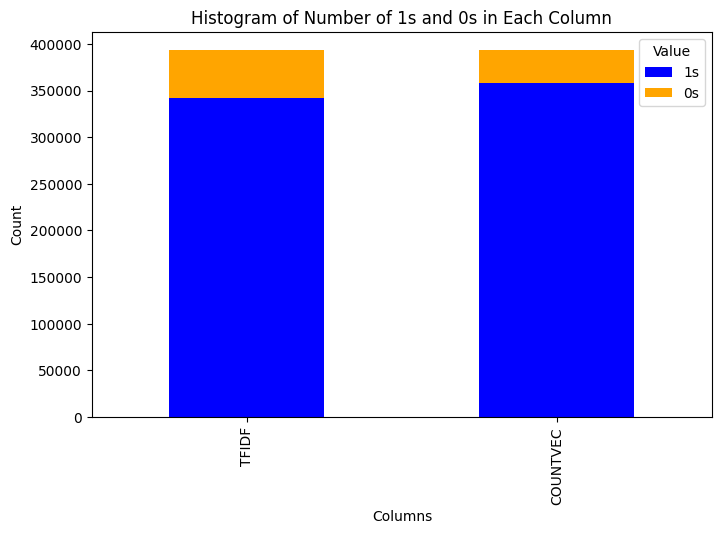

In [41]:
# Sample DataFrame with binary data (0s and 1s)
data = {
    'TFIDF': df['sentiment_tfidf'],
    'COUNTVEC': df['sentiment_count']
}
df_comp = pd.DataFrame(data)

# Count the number of 1s and 0s in each column
count_1s = (df_comp == 1).sum()
count_0s = (df_comp == 0).sum()

# Combine counts into a DataFrame for easier plotting
counts_df = pd.DataFrame({'1s': count_1s, '0s': count_0s})

# Plotting the histogram
counts_df.plot(kind='bar', stacked=True, color=['blue', 'orange'], figsize=(8, 5))
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Histogram of Number of 1s and 0s in Each Column')
plt.legend(title='Value')
plt.show()


In [68]:
matching_count = (df_comp['TFIDF'] == df_comp['COUNTVEC']).sum()
print(matching_count/len(df)*100,'%')

95.96980855509099 %


In [69]:
df.to_csv('/content/drive/MyDrive/Capstone Project/Sentiments_reviews.csv',index=False)